In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import gpflow

In [3]:
import pickle

In [4]:
from helpers import get_scaled_df, data_to_gpr

In [5]:
import matplotlib.pyplot as plt

In [6]:
scaler = pickle.load(open("controller_scaler.pkl", 'rb'))
model = pickle.load(open("controller_model.pkl", 'rb'))
df = pd.read_pickle("controller_df.pkl")
X_log = pickle.load(open("controller_X_log.pkl", 'rb'))

In [7]:
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

t_lags = 0
w_lags = 1
u_lags = 2
y_lags = 3

dict_cols = {
  't': (t_lags, t_cols),
  'w': (w_lags, w_cols),
  'u': (u_lags, u_cols),
 'y': (y_lags, y_cols)
}

In [8]:
pd.DataFrame(X_log[-1])

,0,1,2,3,4,5,6
0,3.629534,-0.043478,0.467424,0.468231,0.814622,0.821869,0.829368
1,3.554404,0.026087,0.472246,0.467424,0.843619,0.814622,0.821869
2,3.455959,0.060870,0.372524,0.472246,0.878315,0.843619,0.814622
3,3.357513,0.095652,0.300814,0.372524,0.878323,0.878315,0.843619
4,3.259067,0.130435,0.249037,0.300814,0.878327,0.878323,0.878315
5,3.044041,0.160870,0.216228,0.249037,0.878321,0.878327,0.878323
6,2.829016,0.191304,0.198559,0.216228,0.878326,0.878321,0.878327
7,2.613990,0.221739,0.193012,0.198559,0.878315,0.878326,0.878321
8,2.398964,0.252174,0.246331,0.193012,0.878319,0.878315,0.878326


In [9]:
df_sc = get_scaled_df(df, dict_cols, scaler)
df_gpr = data_to_gpr(df_sc, dict_cols)

In [10]:
df_gpr

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-1.000000,-1.000000,-0.791304,-0.791304,-0.091754,-0.091754,-0.091754,0.476810,0.556686,0.677723,1.000000
4,-1.000000,-1.000000,-0.791304,-0.791304,-0.091754,-0.091754,-0.091754,0.412944,0.476810,0.556686,0.677723
5,-1.000000,-1.000000,-0.821739,-0.791304,-0.091754,-0.091754,-0.091754,0.357670,0.412944,0.476810,0.556686
6,-1.000000,-1.000000,-0.852174,-0.821739,-0.091754,-0.091754,-0.091754,0.308173,0.357670,0.412944,0.476810
7,-1.000000,-1.000000,-0.882609,-0.852174,-0.091754,-0.091754,-0.091754,0.263350,0.308173,0.357670,0.412944
...,...,...,...,...,...,...,...,...,...,...,...
5136,3.559585,3.414508,-0.147826,-0.204348,0.491535,0.513060,0.538535,0.839457,0.849824,0.863174,0.875588
5137,3.582902,3.559585,-0.113043,-0.147826,0.479890,0.491535,0.513060,0.829368,0.839457,0.849824,0.863174
5138,3.606218,3.582902,-0.078261,-0.113043,0.468231,0.479890,0.491535,0.821869,0.829368,0.839457,0.849824
5139,3.629534,3.606218,-0.043478,-0.078261,0.467424,0.468231,0.479890,0.814622,0.821869,0.829368,0.839457


## Multistep prediction

In [11]:
df_input = df_gpr.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = df_gpr[dict_cols['y'][1]]

In [70]:
start_idx = 600
nb_predictions = 25
N_pred = 20

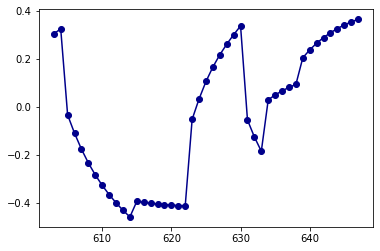

In [71]:
plt.figure()
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [72]:
m = model

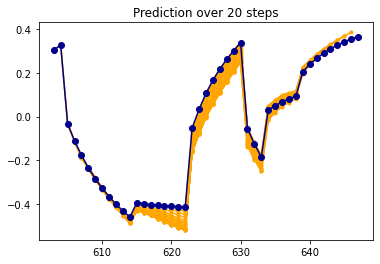

In [73]:
plt.figure()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]
        
    mean_iter, var_iter = m.predict_f(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")
plt.savefig(f"prediction_{N_pred}_steps.png")

In [16]:
df

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
0,0.00,-2.1,-5415.288115,23.000000
1,0.00,-2.1,-5415.288115,17.702812
2,0.00,-2.1,-5415.288115,15.713357
3,0.00,-2.1,-5415.288115,14.400440
4,0.00,-2.1,-5415.288115,13.350697
...,...,...,...,...
5136,440.00,1.6,30874.548732,20.361186
5137,442.25,1.8,30150.065017,20.195354
5138,444.50,2.0,29424.656508,20.072103
5139,446.75,2.2,29374.426928,19.952978


<AxesSubplot:>

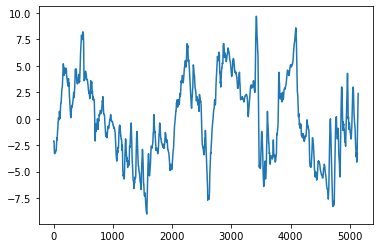

In [17]:
df['OutsideTemp'].plot()